In [1]:
from torch.utils.data import DataLoader


from refactor.utils.hooking import get_activations as get_activations_new
from refactor.utils.compatibility import ModelConfig
from refactor.probes import model_setup
from pathlib import Path
from utils.preprocessing import load_txt_data


"""This function runs an entire pipeline that bootstraps, trains and creates confidence intervals showing
    The probes f1 score on different labels and across layers
    
    We bootstrap 10 times
    Results are saved in this folder: results/data/probe_confidence_intervals/*model_name*_reg_lambda_*reg_lambda*

Args:
    model_name (_type_): _description_
    reg_lambdas (_type_): _description_
"""

#model_name = "downloaded_models/gpt_gptsw3_en_is_da_356m_gbs1024"
model_name = "EleutherAI/pythia-14m"
#model_name = "AI-Sweden-Models/gpt-sw3-356m"

model_name_temp = "pythia-14m"

# loads model
print("Load model")
model, tokenizer, device = model_setup(model_name)

 
# loads data
print("Load data")
data_folder = Path('data/preprocessed/train')

ds = load_txt_data(
    file_paths={
        'da': data_folder / 'da.txt',
        'en': data_folder / 'en.txt',
        'sv': data_folder / 'sv.txt',
        'nb': data_folder / 'nb.txt',
        'is': data_folder / 'is.txt'
    },
    file_extension='txt'
)
loader = DataLoader(ds, batch_size=32, shuffle=True)



# sets training parameters
meta_data = {}
meta_data["hidden_size"] = ModelConfig.hidden_size(model)
meta_data["hidden_layers"] = ModelConfig.hidden_layers(model)
meta_data["model_name"] = model_name.split("/")[0]
meta_data["learning_rate"] = 0.001
meta_data["reg_lambda"] = 10
meta_data["amount_epochs"] = 1


# extracts activation from forward passes on data
# We use hooks to extract the different layer activations that will be used to train our probes

print("Extract activations")
activations = get_activations_new(
    loader=loader, 
    model=model,
    tokenizer=tokenizer,
    hook_addresses=None,
    layers=None,
    max_batches=2,
    sampling_prob=0.1
)


c:\Users\tjupp\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load model
found device: cuda:0
Load data
Extract activations


  3%|▎         | 3/104 [00:09<05:13,  3.11s/it]


In [3]:
activations

{'layer.0.layernorm_1-pre': <refactor.utils.data.ActivationDataset at 0x1fd6bfa1810>,
 'layer.0.attention-pre': <refactor.utils.data.ActivationDataset at 0x1fd6c00b5d0>,
 'layer.0.attention-post': <refactor.utils.data.ActivationDataset at 0x1fd74bd64d0>,
 'layer.0.layernorm_2-pre': <refactor.utils.data.ActivationDataset at 0x1fd74bd6610>,
 'layer.0.mlp-pre': <refactor.utils.data.ActivationDataset at 0x1fd74bd6590>,
 'layer.0.mlp-post': <refactor.utils.data.ActivationDataset at 0x1fd74bd6510>,
 'layer.1.layernorm_1-pre': <refactor.utils.data.ActivationDataset at 0x1fd74bd6490>,
 'layer.1.attention-pre': <refactor.utils.data.ActivationDataset at 0x1fd74bd6450>,
 'layer.1.attention-post': <refactor.utils.data.ActivationDataset at 0x1fd74bd6290>,
 'layer.1.layernorm_2-pre': <refactor.utils.data.ActivationDataset at 0x1fd74bd6350>,
 'layer.1.mlp-pre': <refactor.utils.data.ActivationDataset at 0x1fd74bd6390>,
 'layer.1.mlp-post': <refactor.utils.data.ActivationDataset at 0x1fd74bd6190>,
 'la

In [29]:
model_name_temp = "pythia-14m"


In [18]:
hook_points = ["attention:post","attention:pre","mlp:post","mlp:pre","layernorm_1:pre","layernorm_2:pre"]

In [15]:
from collections import Counter
import torch

top_idx_counter = Counter()
bot_idx_counter = Counter()

for layer in range(4):
    for hook in hook_points:
        flat_tensor = torch.cat(activations[f"layer.{layer}.{hook}"].predictors, dim=0)

        if flat_tensor.numel() == 0:
            continue

        # Top and bottom 10 values
        top_vals, top_idxs = torch.topk(flat_tensor, k=10, largest=True)
        bot_vals, bot_idxs = torch.topk(flat_tensor, k=10, largest=False)

        # Count how often each index appears
        top_idx_counter.update(top_idxs.tolist())
        bot_idx_counter.update(bot_idxs.tolist())

# Find common indices
common_indices = set(top_idx_counter.keys()) & set(bot_idx_counter.keys())

print(f"🔁 Number of shared top/bottom indices: {len(common_indices)}")
print("🧠 Shared neuron indices with their counts in top and bottom:")
for idx in common_indices:
    print(f"Index {idx}: Top {top_idx_counter[idx]} times, Bottom {bot_idx_counter[idx]} times")


🔁 Number of shared top/bottom indices: 6
🧠 Shared neuron indices with their counts in top and bottom:
Index 11385: Top 1 times, Bottom 1 times
Index 18904: Top 1 times, Bottom 1 times
Index 12025: Top 1 times, Bottom 1 times
Index 8953: Top 1 times, Bottom 1 times
Index 11352: Top 1 times, Bottom 1 times
Index 18937: Top 1 times, Bottom 1 times


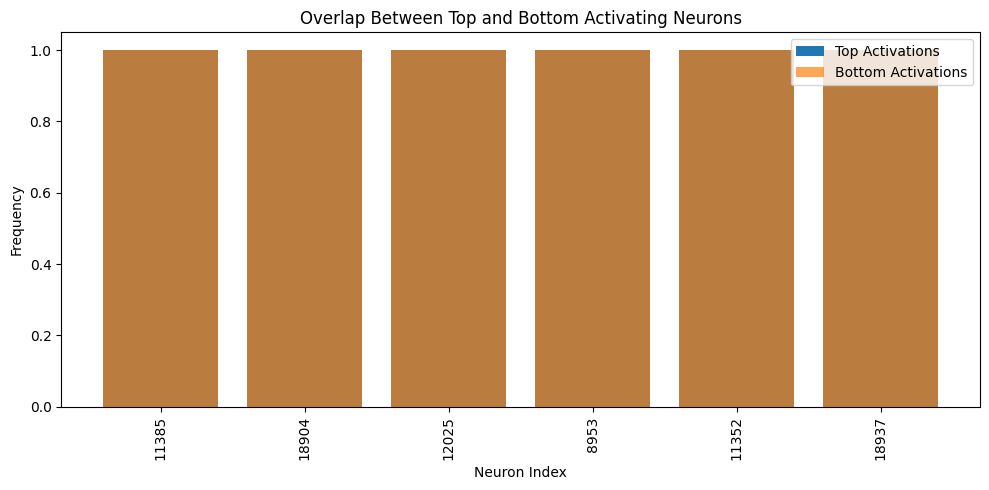

In [16]:

import pandas as pd
import matplotlib.pyplot as plt

data = []
for idx in common_indices:
    data.append({
        "index": idx,
        "top_count": top_idx_counter[idx],
        "bottom_count": bot_idx_counter[idx]
    })

df = pd.DataFrame(data).sort_values("top_count", ascending=False)

# Plot
plt.figure(figsize=(10, 5))
plt.bar(df["index"].astype(str), df["top_count"], label="Top Activations")
plt.bar(df["index"].astype(str), df["bottom_count"], label="Bottom Activations", alpha=0.7)
plt.xlabel("Neuron Index")
plt.ylabel("Frequency")
plt.title("Overlap Between Top and Bottom Activating Neurons")
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


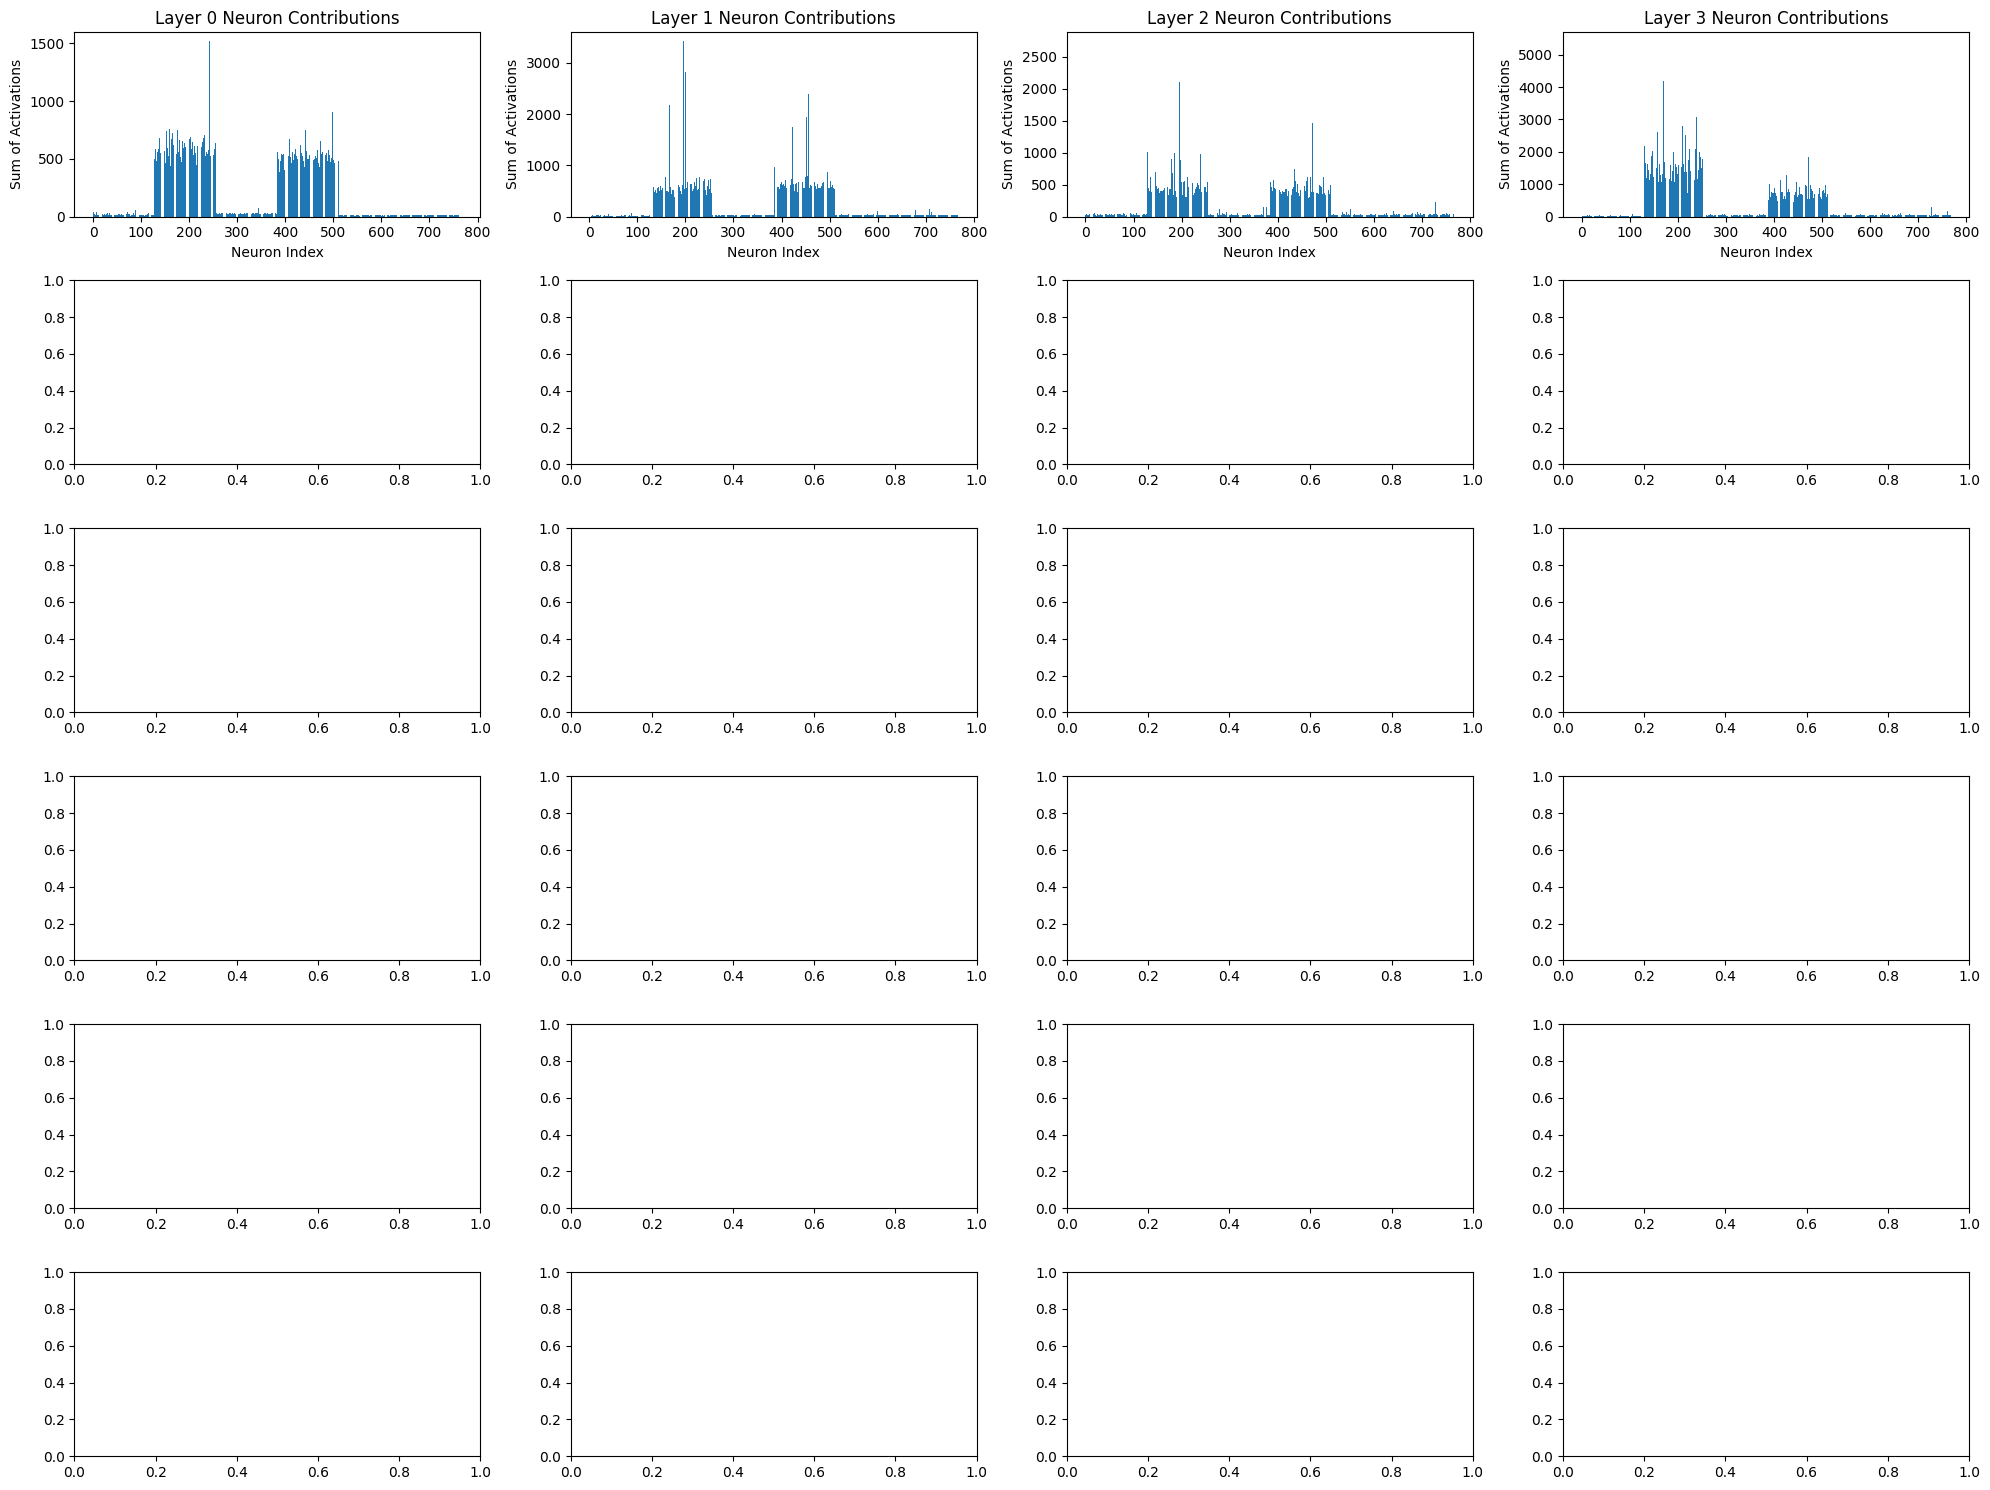

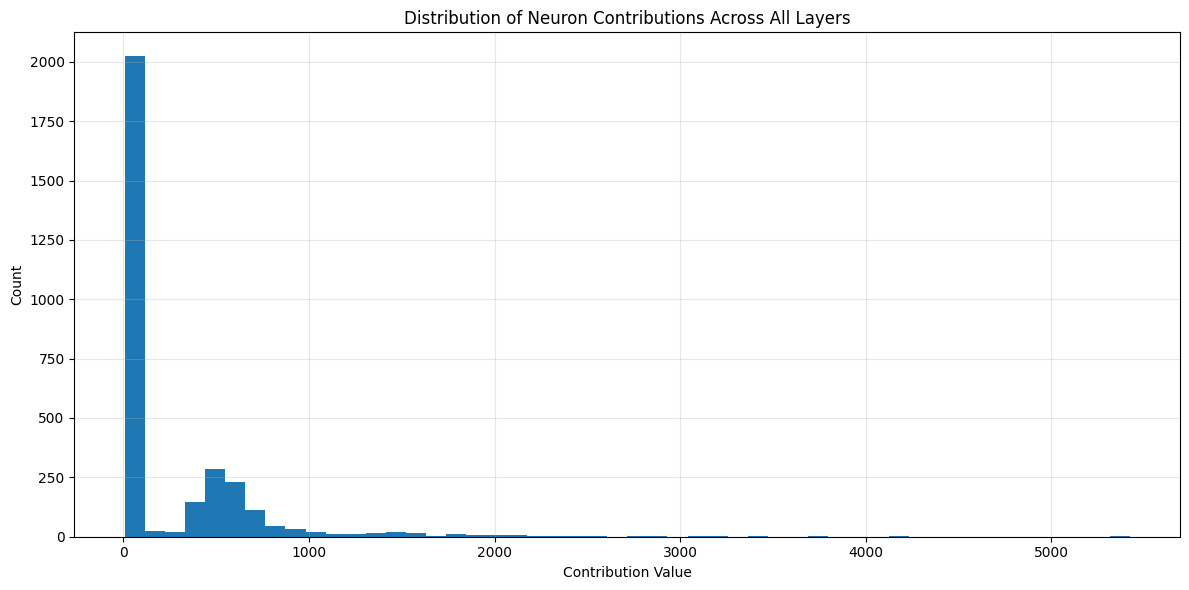

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Continuing from where you left off...
# Assuming for layer in range(24):
#    for hook in hook_points:
#        activ_list = activations[f"layer.{layer}.{hook}"].predictors

# Let's calculate the neuron contributions for each layer
num_layers = 4
neuron_contributions = {}

for layer in range(num_layers):
    # Get all activations for this layer and sum them
    layer_activations = []
    
    for hook in hook_points:
        activ_list = activations[f"layer.{layer}.{hook}"].predictors
        
        # Stack all tensors in activ_list
        stacked_activations = torch.stack(activ_list)
        
        # Take absolute values and sum across all dimensions except the neuron dimension
        # Assuming the last dimension is the neuron dimension
        neuron_sums = torch.abs(stacked_activations).sum(dim=0)
        
        # Add to our layer activations
        layer_activations.append(neuron_sums)
    
    # Concatenate all activations for this layer
    all_layer_activations = torch.cat(layer_activations)
    
    # Store in our dictionary
    neuron_contributions[layer] = all_layer_activations.cpu().numpy()

# Create a figure with subplots for each layer
fig, axs = plt.subplots(6, 4, figsize=(20, 15))
axs = axs.flatten()

# Plot histograms for each layer
for layer in range(num_layers):
    contributions = neuron_contributions[layer]
    x = np.arange(len(contributions))
    
    # Plot as a bar chart with neuron index on x-axis and contribution on y-axis
    axs[layer].bar(x, contributions)
    axs[layer].set_title(f'Layer {layer} Neuron Contributions')
    axs[layer].set_xlabel('Neuron Index')
    axs[layer].set_ylabel('Sum of Activations')

plt.tight_layout()
plt.savefig('neuron_contributions.png')
plt.show()

# Plot an overall summary of the most active neurons
plt.figure(figsize=(12, 6))

# Flatten all contributions
all_contributions = np.concatenate([neuron_contributions[layer] for layer in range(num_layers)])

# Create a histogram of all contributions
plt.hist(all_contributions, bins=50)
plt.title('Distribution of Neuron Contributions Across All Layers')
plt.xlabel('Contribution Value')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('overall_contributions.png')
plt.show()

In [19]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math

# Continuing from where you left off...
# Assuming you have a list called hook_points with all your hook names

# Calculate neuron contributions for each layer and hook point separately
num_layers = 5
neuron_contributions = {}

for layer in range(num_layers):
    for hook in hook_points:
        # Get activations for this specific layer and hook point
        activ_list = activations[f"layer.{layer}.{hook}"].predictors
        
        # Stack all tensors in activ_list
        stacked_activations = torch.stack(activ_list)
        
        # Take absolute values and sum across all dimensions except the neuron dimension
        # Assuming the last dimension is the neuron dimension
        neuron_sums = torch.abs(stacked_activations).sum(dim=0)
        
        # Store in our dictionary with a key that identifies both layer and hook
        key = (layer, hook)
        neuron_contributions[key] = neuron_sums.cpu().numpy()
        

In [22]:
import pickle
# Save to file
with open(f'results/data/neuron_contributions/pythia-14m.pkl', 'wb') as f:
    pickle.dump(neuron_contributions, f)

In [ ]:
import os
import math
import matplotlib.pyplot as plt
import numpy as np

# Ensure output directory exists
os.makedirs("results/neuron_contributions", exist_ok=True)

cols = 6
plots_per_row = cols
total_plots = num_layers * len(hook_points)
rows = math.ceil(total_plots / cols)

plot_idx = 0

# Flatten list of all (layer, hook) combinations
all_keys = [(layer, hook) for layer in range(num_layers) for hook in hook_points]

for layer in range(num_layers):
    fig, axs = plt.subplots(1, len(hook_points), figsize=(20, 4))
    axs = axs.flatten()

    for i, hook in enumerate(hook_points):
        contributions = neuron_contributions[(layer, hook)]
        x = np.arange(len(contributions))
        axs[i].bar(x, contributions)
        axs[i].set_title(f'{hook}')
        axs[i].set_xlabel('Neuron Index')
        axs[i].set_ylabel('Sum of Activations')
        axs[i].set_ylim(0, max(contributions) * 1.3)
        # Highlight neurons with c*ontribution > 4 × average
        avg = contributions.mean()
        for neuron_idx, value in enumerate(contributions):
            if value > 2.5 * avg:
                axs[i].text(
                    neuron_idx, value, f'N{neuron_idx}',
                    ha='center', va='bottom', fontsize=8, rotation=90
                )

    plt.tight_layout()
    plt.savefig(f'results/neuron_contributions/{model_name_temp}_layer_{layer}.png', dpi=300, bbox_inches='tight')
    plt.close(fig)  # Free memory


In [34]:
contributions

array([ 67.088615, 104.07859 ,  40.436287,  40.69847 ,  51.895683,
        27.218689,  26.298895,  52.093395,  31.431507,  26.982416,
        61.968113,  35.217373, 107.857895,  40.6189  ,  35.48936 ,
        24.125523,  54.833366,  61.39806 ,  42.068848,  49.937687,
        34.470818,  56.59351 ,  31.565636,  69.05467 ,  49.428047,
        33.38829 ,  30.269207,  37.497276,  40.02301 ,  50.964447,
        29.575293,  55.022694,  53.066174,  34.53501 ,  49.739246,
        35.844635,  56.61886 ,  49.965645,  25.609318,  33.11594 ,
        30.650476,  44.702396,  52.661983,  32.434464,  33.877438,
        49.51655 ,  65.32115 ,  26.159557,  52.46194 ,  53.02694 ,
        71.13538 ,  63.70706 ,  79.69519 ,  44.11182 ,  28.604774,
        32.755882,  41.079716,  39.147324,  31.108635,  32.370403,
        49.259636,  38.90837 ,  36.03365 ,  42.75563 ,  43.750507,
        36.35061 ,  29.945726,  40.484608,  43.092804,  30.533024,
        50.177544,  45.840317,  39.315872,  52.80161 ,  43.246

In [33]:
np.average(contributions)

46.008377

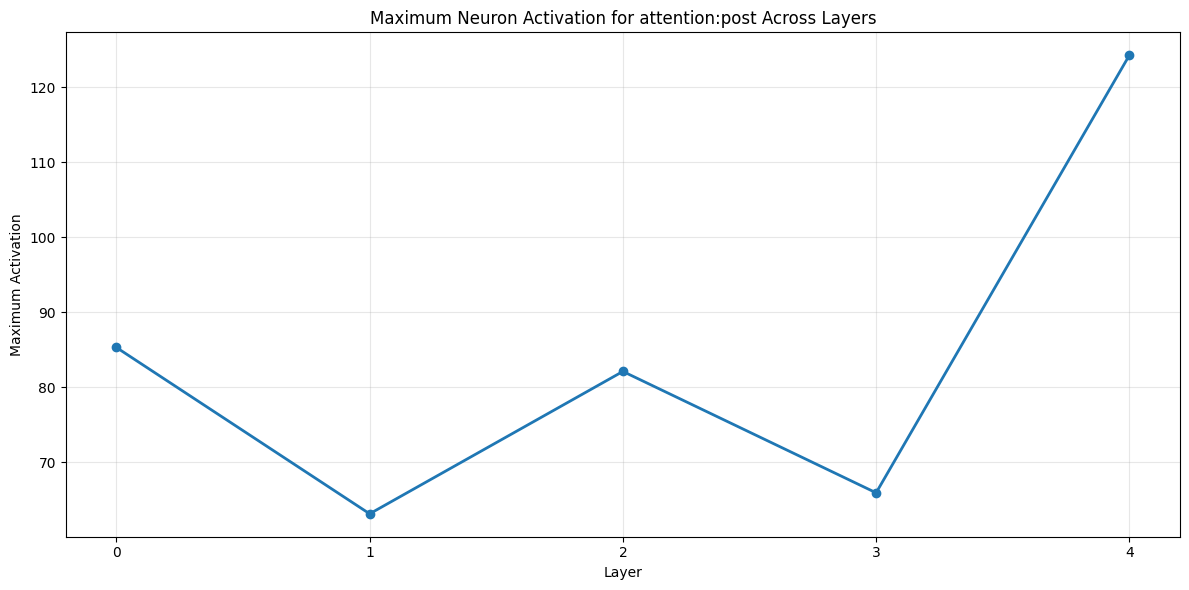

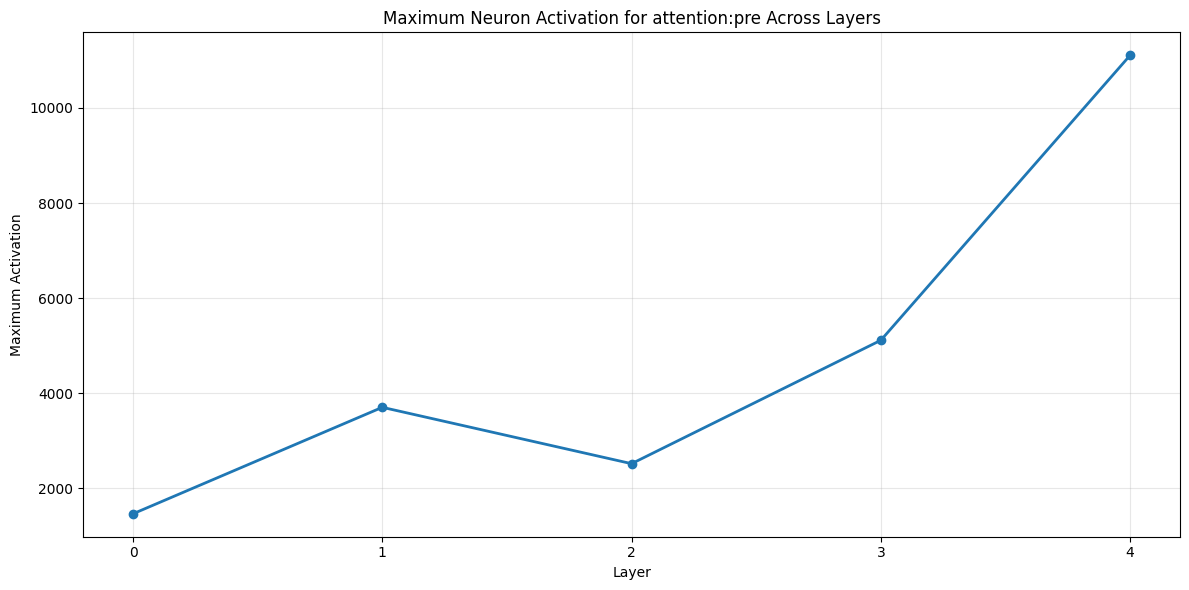

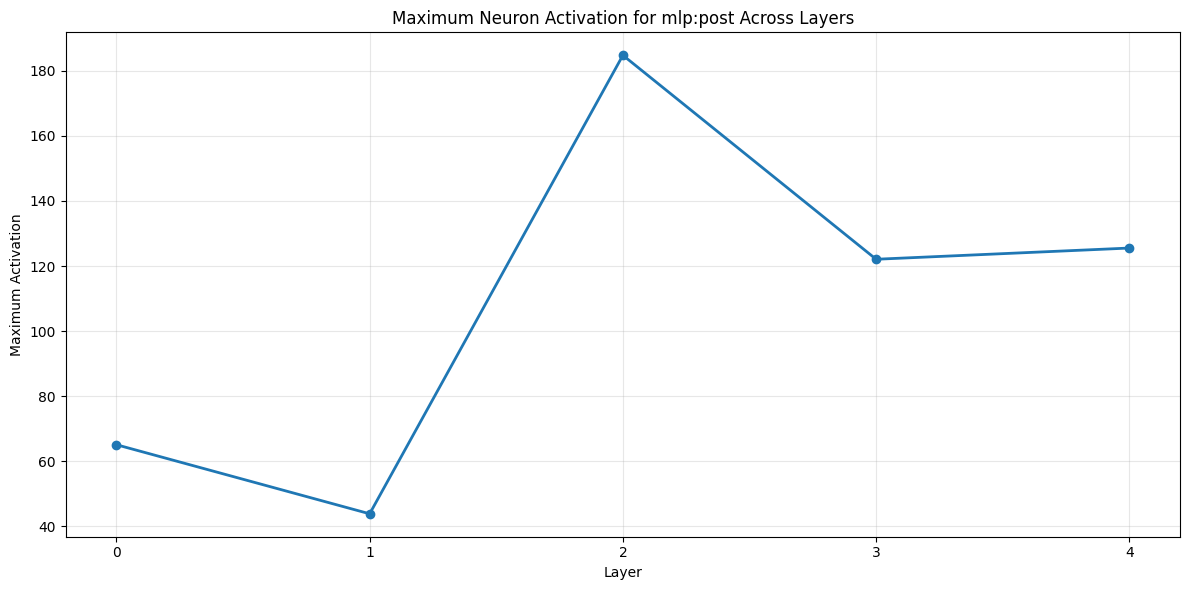

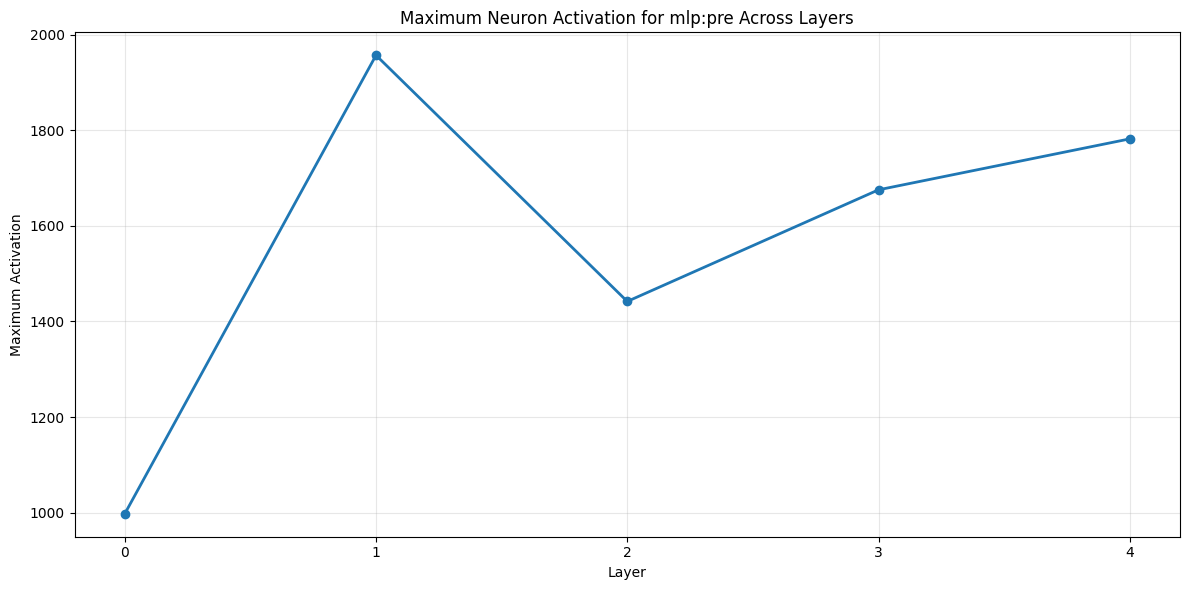

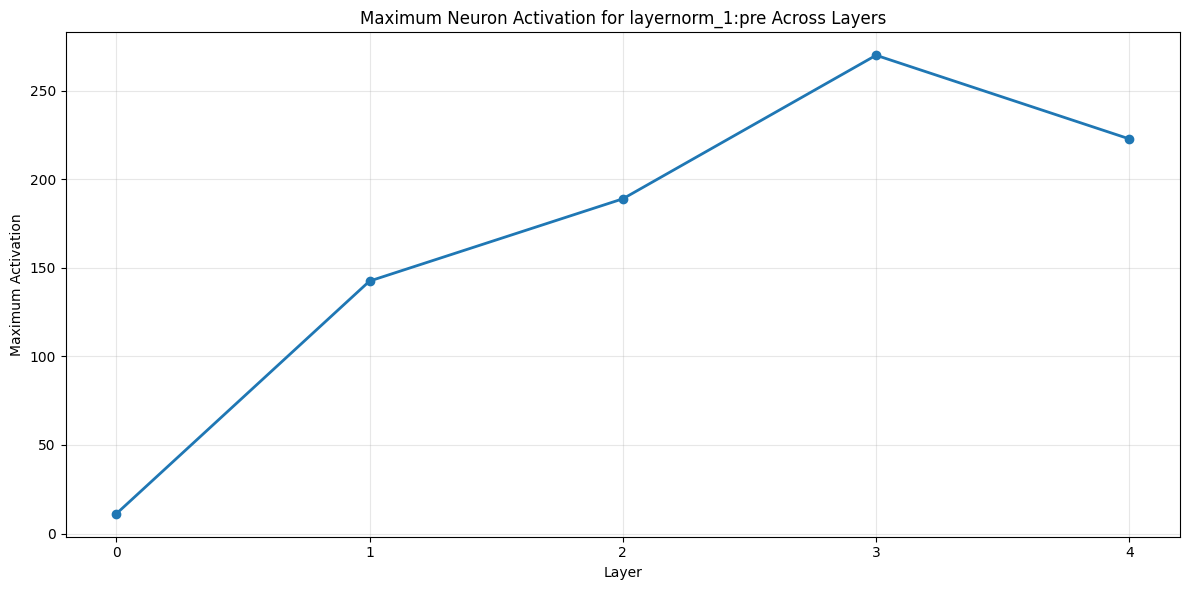

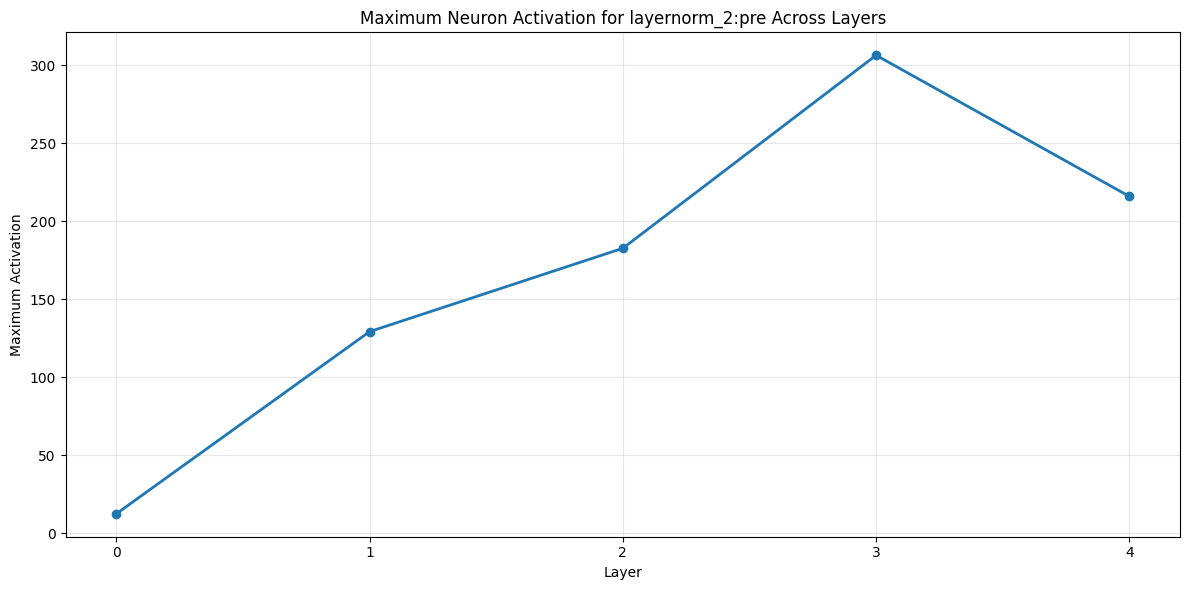

In [26]:
# Additionally, create summary plots for each hook point across all layers
for hook in hook_points:
    plt.figure(figsize=(12, 6))
    
    # Get max value for consistent y-axis scaling
    max_val = max([neuron_contributions[(layer, hook)].max() for layer in range(num_layers)])
    
    # Plot line graph showing the maximum activation for each layer
    max_activations = [neuron_contributions[(layer, hook)].max() for layer in range(num_layers)]
    plt.plot(range(num_layers), max_activations, 'o-', linewidth=2)
    plt.grid(True, alpha=0.3)
    plt.title(f'Maximum Neuron Activation for {hook} Across Layers')
    plt.xlabel('Layer')
    plt.ylabel('Maximum Activation')
    plt.xticks(range(num_layers))
    
    plt.tight_layout()
    plt.savefig(f'max_activation_{hook}.png')
    plt.show()

In [8]:
stacked_activations.shape

torch.Size([385, 128])

In [11]:
neuron_contributions

{(0,
  'attention:post'): array([11.991009 , 38.397255 , 10.437637 , 19.519064 , 13.336708 ,
        11.647591 , 17.754818 , 38.033215 , 18.38054  , 13.540211 ,
        17.579885 , 13.417167 , 17.311419 , 27.683521 , 11.407908 ,
        13.986622 , 12.549254 , 14.1598   , 17.880167 , 18.64138  ,
        21.098206 , 10.925859 , 13.734459 , 16.030056 , 18.36574  ,
        17.805449 , 14.169519 , 15.844341 , 18.264631 , 11.922487 ,
        31.94363  , 10.557545 , 13.146715 , 19.732635 , 27.350946 ,
        11.471746 , 12.225141 , 20.638414 ,  9.316282 , 71.12186  ,
        10.8381   , 17.626728 , 10.420616 ,  7.8042407, 20.948395 ,
        11.657745 ,  9.516411 , 15.414579 , 14.708452 , 12.799438 ,
        22.678497 , 11.726001 ,  9.515823 , 25.318071 , 13.734974 ,
        18.511694 , 11.618071 , 11.3558445,  8.593185 , 20.400185 ,
         9.581903 ,  9.945498 , 10.616292 , 13.354452 , 12.703541 ,
        21.009192 , 26.712547 , 30.060411 , 99.835724 , 14.18663  ,
        19.776184 , 10.